In [27]:
import numpy as np
from brian2 import *
from random import randrange
from collections import Counter
import math

In [37]:
def make_poisson_pattern_current(N , patterns , duration , delta_time , possibility):
    l = 0
    for i in patterns:
        if max(i) > l:
            l = max(i)
            
    which_neuron = []
    spike_time = []
    pattern_time = []
    which_pattern = []
    
    pre = 0
    for i in range (int((duration/ms - 400) /(delta_time/ms *l))):
        base = i*l
        choice = np.random.choice([1,0],p=[possibility , 1-possibility])
        
        if pre == 1:
            choice = 0
            pre = 0
            
        if choice == 1:
            pre = 1
            pattern_time.append(base * delta_time/ms)
            pattern_number = randrange(len(patterns))
            which_pattern.append(pattern_number)
            
        for j in range(N):
            if choice == 0:
                rand = randrange(0,l+1)
                if rand == 0:
                    continue
                spike_time.append((base + rand)*(delta_time/ms) * ms)
                which_neuron.append(j)
                
            if choice == 1:
                if patterns[pattern_number][j] != 0:
                    which_neuron.append(j)
                    spike_time.append((base + patterns[pattern_number][j])*(delta_time/ms)* ms)
                    
                        
    which_pattern.append(0)
    pattern_time.append(duration/ms - 300)
    for i in range(N):
        if patterns[0] != 0:
            which_neuron.append(i)
            spike_time.append(((duration/ms-300)/(delta_time/ms) + patterns[0][i])*(delta_time/ms)* ms)
#             print(spike_time[-1])
    
    which_pattern.append(1)
    pattern_time.append(duration/ms - 200)
    for i in range(N):
        if patterns[1] != 0:
            which_neuron.append(i)
            spike_time.append(((duration/ms-200)/(delta_time/ms) + patterns[1][i])*(delta_time/ms)* ms)
#             print(spike_time[-1])
            
    for i in range(1):
        base = ((duration/ms - 100) / (delta_time / ms)) + i*l
        for j in range(N):
            rand = randrange(0,l+1)
            if rand == 0:
                continue
            spike_time.append((base + rand)*(delta_time/ms) * ms)
            which_neuron.append(j)
    
    return which_neuron , spike_time , pattern_time , which_pattern , l*delta_time/ms

In [29]:
def pulse_input_current_generator(max_I,delta_time,duration,possibility):
    output = TimedArray([np.random.choice([max_I,0],p=[possibility,1 - possibility]) * namp for i in range(int(duration/delta_time))],delta_time)
    return output

In [42]:
def simulate (coef = 2 , duration = 200*ms , Apre=2 , I_1 = 2 * Mohm , p_1 = 0.1 , I_2 = 2 * Mohm , p_2 = 0.1 , p_pattern = 0.40 , tau_pre = 12*ms 
              , u_rest_post_1 = -70 * mV, tau_post_1 = 14 * ms , threshold_post_1 = -55 * mV , Resistance_post_1 = 8 * Mohm
              , u_rest_post_2 = -70 * mV, tau_post_2 = 11 * ms , threshold_post_2 = -55 * mV , Resistance_post_2 = 6 * Mohm
              , u_rest_post_3 = -70 * mV, tau_post_3 = 11 * ms , threshold_post_3 = -55 * mV , Resistance_post_3 = 6 * Mohm):
    
    start_scope()
    delta_time = 0.5 * ms
    wmax = 1
#     Apost = -Apre * tau_pre / tau_post_1
    Apost = -Apre

    
    which_neuron , spike_time , pattern_time , which_pattern , l= make_poisson_pattern_current(10 , [[1,1,1,4,4,4,9,9,9,0],[1,1,1,1,1,9,9,9,9,9]] , duration , delta_time , p_pattern)
    pre = SpikeGeneratorGroup(10, which_neuron, spike_time)
    
    input_current_post_1 = pulse_input_current_generator(I_1 , delta_time , duration , p_1)

    
    eqs_post_1 = '''
        du/dt = -(u-u_rest)/tau + Resistance * input_current_post_1(t)/tau : volt
        tau : second
        u_rest : volt
        Resistance : ohm
    '''
    post_1 = NeuronGroup(1,eqs_post_1,threshold='u>threshold_post_1', reset='u=u_rest_post_1',method='linear')
    
    post_1.u = u_rest_post_1
    post_1.tau = tau_post_1
    post_1.u_rest = u_rest_post_1
    post_1.Resistance = Resistance_post_1
    
    eqs_post_2 = '''
        du/dt = -(u-u_rest)/tau + Resistance * input_current_post_1(t)/tau : volt
        tau : second
        u_rest : volt
        Resistance : ohm
    '''
    post_2 = NeuronGroup(1,eqs_post_2,threshold='u>threshold_post_2', reset='u=u_rest_post_2',method='linear')
    
    post_2.u = u_rest_post_2
    post_2.tau = tau_post_2
    post_2.u_rest = u_rest_post_2
    post_2.Resistance = Resistance_post_2
    
    eqs_post_3 = '''
        du/dt = -(u-u_rest)/tau + Resistance * input_current_post_1(t)/tau : volt
        tau : second
        u_rest : volt
        Resistance : ohm
    '''
    post_3 = NeuronGroup(1,eqs_post_3,threshold='u>threshold_post_3', reset='u=u_rest_post_3',method='linear')
    
    post_3.u = u_rest_post_3
    post_3.tau = tau_post_3
    post_3.u_rest = u_rest_post_3
    post_3.Resistance = Resistance_post_3
    
    syn_1 = Synapses (pre , post_1 ,
             '''
             w : 1
             dapre/dt = -apre/tau_pre : 1 
             dapost/dt = -apost/tau_post_1 : 1 
             ''' ,
             on_pre= '''
             u_post += w*coef * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn_1.connect(p=1)
    syn_1.w = [0.4 + random()*0.2 for i in range(10)]
    syn_1.delay = 1 * delta_time
    
    syn_2 = Synapses (pre , post_2 ,
             '''
             w : 1
             dapre/dt = -apre/tau_pre : 1 
             dapost/dt = -apost/tau_post_2 : 1 
             ''' ,
             on_pre= '''
             u_post += w*coef * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn_2.connect(p=1)
    syn_2.w = [0.4 + random()*0.2 for i in range(10)]
    syn_2.delay = 1 * delta_time
    
    syn_3 = Synapses (pre , post_3 ,
             '''
             w : 1
             dapre/dt = -apre/tau_pre : 1 
             dapost/dt = -apost/tau_post_3 : 1 
             ''' ,
             on_pre= '''
             u_post += w*coef * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn_3.connect(p=1)
    syn_3.w = [0.4 + random()*0.2 for i in range(10)]
    syn_3.delay = 0 * delta_time
    
    syn_4 = Synapses (post_3 , post_2 ,
             '''
             w : 1
             dapre/dt = -apre/tau_post_3 : 1 
             dapost/dt = -apost/tau_post_2 : 1 
             ''' ,
             on_pre= '''
             u_post -= w*coef * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn_4.connect(p=1)
    syn_4.w = 0.4 + random()*0.2
    syn_4.delay = 0 * delta_time
    
    syn_5 = Synapses (post_3 , post_1 ,
             '''
             w : 1
             dapre/dt = -apre/tau_post_3 : 1 
             dapost/dt = -apost/tau_post_1 : 1 
             ''' ,
             on_pre= '''
             u_post -= w*coef * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn_5.connect(p=1)
    syn_5.w = 0.4 + random()*0.2
    syn_5.delay = 0 * delta_time
    
    
    u_mon_1 = StateMonitor(post_1 , 'u' , record = True)
    u_mon_2 = StateMonitor(post_2 , 'u' , record = True)
    u_mon_3 = StateMonitor(post_3 , 'u' , record = True)
    
    M_1 = StateMonitor(syn_1, ['w', 'apre', 'apost'], record=True)
    M_2 = StateMonitor(syn_2, ['w', 'apre', 'apost'], record=True)
    
    s1_1 = SpikeMonitor(post_1)
    s1_2 = SpikeMonitor(post_2)
    s1_3 = SpikeMonitor(post_3)
    s2 = SpikeMonitor(pre)
    
    run(duration)
    
    figure(figsize=(14, 14))
    subplot(911)
#     plot(u_mon.t/ms , u_mon.u[0]/mV, label = '0')
#     plot(u_mon.t/ms , u_mon.u[1]/mV, label = '1')
#     for i in range (len(pattern_time)):
#         if which_pattern[i] == 0:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
#         else:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
#     for i in range(2):
    plot(M_1.t/ms, M_1.apre[1], label='apre '+str(0))
    plot(M_1.t/ms, M_1.apost[1], label='apost '+str(0))
    plt.axhline(color='red')
        
#     for i in range (len(pattern_time)):
#         if which_pattern[i] == 0:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
#         else:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    legend()
    subplot(912)
    plt.axhline(y=u_rest_post_1/mV , color='red')
    plt.axhline(y=threshold_post_1/mV , color='red')
#     post_1_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][0])/ms)])))
#     post_2_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][1])/ms)])))
    
#     plot(list(Counter(post_1_spike_times).keys()) ,list(Counter(post_1_spike_times).values()),label = 'post1')
#     plot(list(Counter(post_2_spike_times).keys()) ,list(Counter(post_2_spike_times).values()),label = 'post2')
#     for i in range(10):
#     plot(M.t/ms, M.w[0], label='w')
#     legend(loc='best')
#     xlabel('Time (ms)')
#     ylabel('W (mV)')
    plot(u_mon_1.t/ms , u_mon_1.u[0]/mV, label = 'ex_1')
#     plot(u_mon.t/ms , u_mon.u[1]/mV, label = '1')
    legend()
#     plot(u_mon.t/ms , u_mon.u[4], label = '1')
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
            
    subplot(913)
    plt.axhline(y=u_rest_post_2/mV , color='red')
    plt.axhline(y=threshold_post_2/mV , color='red')
#     post_1_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][0])/ms)])))
#     post_2_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][1])/ms)])))
    
#     plot(list(Counter(post_1_spike_times).keys()) ,list(Counter(post_1_spike_times).values()),label = 'post1')
#     plot(list(Counter(post_2_spike_times).keys()) ,list(Counter(post_2_spike_times).values()),label = 'post2')
#     for i in range(10):
#     plot(M.t/ms, M.w[0], label='w')
#     legend(loc='best')
#     xlabel('Time (ms)')
#     ylabel('W (mV)')
    plot(u_mon_2.t/ms , u_mon_2.u[0]/mV, label = 'ex_2')
#     plot(u_mon.t/ms , u_mon.u[1]/mV, label = '1')
    legend()
#     plot(u_mon.t/ms , u_mon.u[4], label = '1')
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
            
    subplot(914)
    plt.axhline(y=u_rest_post_3/mV , color='red')
    plt.axhline(y=threshold_post_3/mV , color='red')
#     post_1_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][0])/ms)])))
#     post_2_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][1])/ms)])))
    
#     plot(list(Counter(post_1_spike_times).keys()) ,list(Counter(post_1_spike_times).values()),label = 'post1')
#     plot(list(Counter(post_2_spike_times).keys()) ,list(Counter(post_2_spike_times).values()),label = 'post2')
#     for i in range(10):
#     plot(M.t/ms, M.w[0], label='w')
#     legend(loc='best')
#     xlabel('Time (ms)')
#     ylabel('W (mV)')
    plot(u_mon_3.t/ms , u_mon_3.u[0]/mV, label = 'inh')
#     plot(u_mon.t/ms , u_mon.u[1]/mV, label = '1')
    legend()
#     plot(u_mon.t/ms , u_mon.u[4], label = '1')
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
            

            
    subplot(915)
    plt.axhline(y=u_rest_post_1/mV , color='red')
    plt.axhline(y=threshold_post_1/mV , color='red')
#     last = int(duration/ms * delta_time/ms / 10)
#     if last > 500:
#         last = 500

    last = 350
        
    plot(u_mon_1.t[-last*10:-1]/ms , u_mon_1.u[0][-last*10:-1]/mV, label = '0')
    for i in range (len(pattern_time)):
        if pattern_time[i] < duration/ms - last:
            continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
            
    subplot(916)
    plt.axhline(y=u_rest_post_2/mV , color='red')
    plt.axhline(y=threshold_post_2/mV , color='red')
    plot(u_mon_2.t[-last*10:-1]/ms , u_mon_2.u[0][-last*10:-1]/mV, label = '1',color = 'orange')
    for i in range (len(pattern_time)):
        if pattern_time[i] < duration/ms - last:
            continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
            
    subplot(917)
#     plot(M_1.t[-last*10:-1]/ms, M_1.w[1][-last*10:-1], label='w_0')
    plot(M_1.t/ms, M_1.w[0], label='w_1_0')
    plot(M_1.t/ms, M_1.w[1], label='w_1_1')
    plot(M_1.t/ms, M_1.w[2], label='w_1_2')
    plot(M_1.t/ms, M_1.w[3], label='w_1_3')
    plot(M_1.t/ms, M_1.w[4], label='w_1_4')
    
    plot(M_2.t/ms, M_2.w[0], label='w_2_0')
    plot(M_2.t/ms, M_2.w[1], label='w_2_1')
    plot(M_2.t/ms, M_2.w[2], label='w_2_2')
    plot(M_2.t/ms, M_2.w[3], label='w_2_3')
    plot(M_2.t/ms, M_2.w[4], label='w_2_4')
    
#     plot(M.t[-last*10:-1]/ms, M.w[10][-last*10:-1], label='w_1')
    legend()
#     plot(M.t/ms, M.w[2], label='w')
#     plot(M.t/ms, M.w[3], label='w')
#     plot(M.t/ms, M.w[4], label='w')
    subplot(918)
    plot(s1_1.t/ms,s1_1.i, 'ok', ms=1)
    plot(s1_2.t/ms,[x+1 for x in s1_2.i], 'ok', ms=1)
    plot(s1_3.t/ms,[x+2 for x in s1_3.i], 'ok', ms=1)
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    subplot(919)
    plot(s2.t/ms,s2.i, 'ok', ms=1)
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
#     return s1
    return M_1 , M_2 , s1_1 , s1_2 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon_1 , u_mon_2

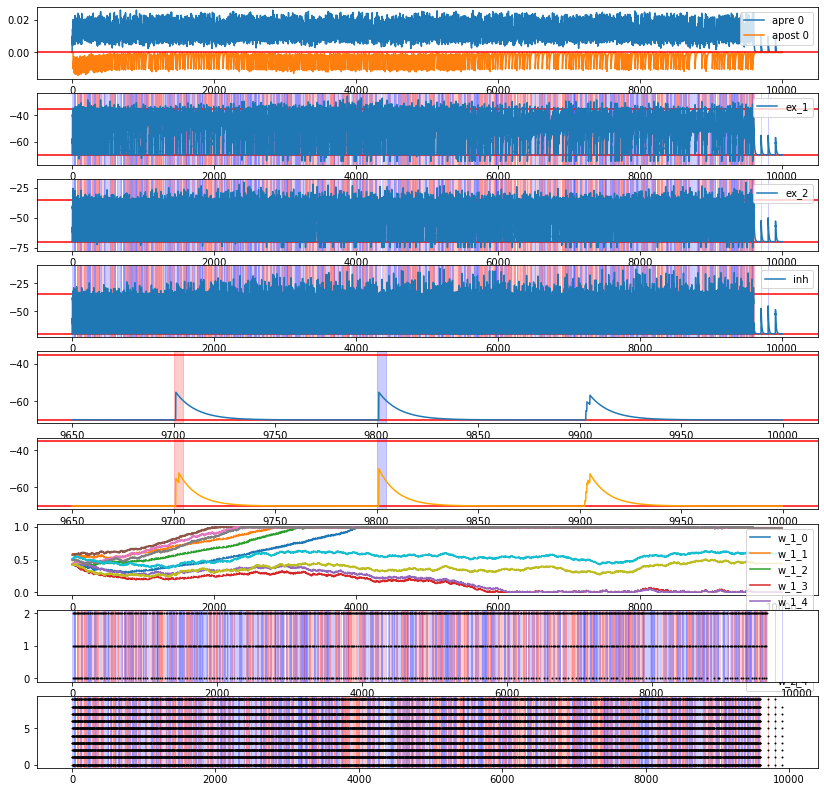

In [44]:
M_1 , M_2 , s1_1 , s1_2 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon_1 , u_mon_2 = simulate (coef = 5,
      duration = 10000*ms , Apre=0.01 , I_1 = 0 * Mohm , p_1 = 0 , I_2 = 0 * Mohm , p_2 = 0 , p_pattern = .7 , tau_pre =6*ms 
              , u_rest_post_1 = -70 * mV, tau_post_1 = 10 * ms , threshold_post_1 = -35 * mV , Resistance_post_1 = 10 * Mohm
              , u_rest_post_2 = -70 * mV, tau_post_2 = 9 * ms , threshold_post_2 = -35 * mV , Resistance_post_2 = 10 * Mohm
              , u_rest_post_3 = -70 * mV, tau_post_3 = 9 * ms , threshold_post_3 = -35 * mV , Resistance_post_3 = 10 * Mohm)